In [2]:
import json
import numpy as np
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
DATA_PATH = "music.json"

In [3]:
def load_data(data_path):
    
    with open(data_path, "r") as fp:
        data = json.load(fp)

    x = data["mfcc"]       
    list = []
    for i in range(len(x)):
        list.append(len(x[i]))
    
    size = min(list)    

    newX = []
    for i in range(len(x)):
        arr = x[i]
        arr = arr[:size]
        np_array = np.array(arr)
#         p = np.pad(np_array, ((22,22),(90,90)))
        p = np.pad(np_array, ((0,0),(40,40)))
        newX.append(p)
    x = np.array(newX)
    y = np.array(data["label"], dtype=object)
    return x, y 




In [4]:
X, y = load_data(DATA_PATH)
X.shape

(900, 149, 92)

In [5]:
y.shape

(900,)

In [6]:
def convert_to_tf(arr):
    return tf.convert_to_tensor(arr, dtype=tf.float32)

In [11]:
def prepare_datasets(test_size, validation_size):
  

    # load data
    X, y = load_data(DATA_PATH)
#     X = (X-X.min())/(X.max()-X.min())
    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return convert_to_tf(X_train), convert_to_tf(X_validation), convert_to_tf(X_test), convert_to_tf(y_train), convert_to_tf(y_validation), convert_to_tf(y_test)


In [12]:
def build_model(input_shape):
  
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(21, activation='softmax'))

    return model

In [13]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


In [14]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # train model
    history=  model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)    
    X_to_predict = X_test[10]
    y_to_predict = y_test[10]

    # predict sample
    predict(model, X_to_predict, y_to_predict)    

Epoch 1/30
17/17 [==============================] - 5s 272ms/step - loss: 3.2070 - accuracy: 0.0870 - val_loss: 4.5231 - val_accuracy: 0.0370
Epoch 2/30
17/17 [==============================] - 5s 295ms/step - loss: 2.7294 - accuracy: 0.1611 - val_loss: 3.7061 - val_accuracy: 0.0370
Epoch 3/30
17/17 [==============================] - 5s 280ms/step - loss: 2.4430 - accuracy: 0.2630 - val_loss: 3.4918 - val_accuracy: 0.0519
Epoch 4/30
17/17 [==============================] - 5s 292ms/step - loss: 2.2449 - accuracy: 0.3222 - val_loss: 3.1540 - val_accuracy: 0.1333
Epoch 5/30
17/17 [==============================] - 4s 262ms/step - loss: 2.0479 - accuracy: 0.3926 - val_loss: 3.0803 - val_accuracy: 0.1185
Epoch 6/30
17/17 [==============================] - 4s 260ms/step - loss: 1.8875 - accuracy: 0.4222 - val_loss: 2.8397 - val_accuracy: 0.1481
Epoch 7/30
17/17 [==============================] - 5s 307ms/step - loss: 1.8310 - accuracy: 0.4500 - val_loss: 2.6762 - val_accuracy: 0.1481
Epoch 

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 147, 91, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 46, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 46, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 22, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 22, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 21, 32)        4

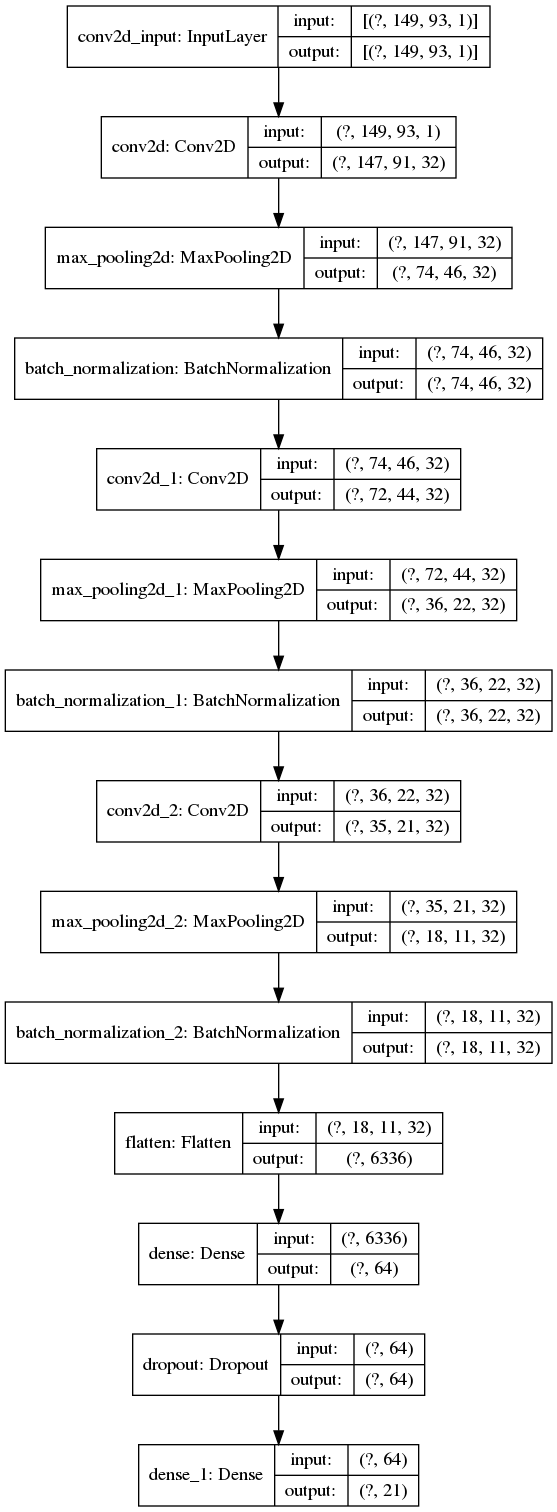

In [11]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True )

In [14]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)


In [ ]:
X_train.shape

In [ ]:
classes =  ["flute", "clarinet","french horn","marimba","contrabassoon",
            "violin","bassoon","bass guitar","drums","harp","harmonica","lute", "piano","organ","bagpipes",
        "guitar","electic guitar","Banjo","bugle","Accordion"]
len(classes)

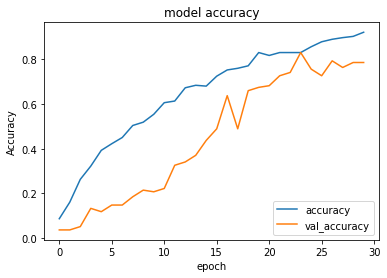

In [18]:
# plotting training and validation accuracy 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(loc='lower right')
plt.savefig('BasicAccuracy.png')
plt.show()

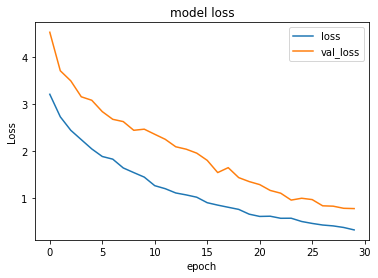

In [19]:
# plotting loss accuracy 
plt.plot(history.history["loss"],label='loss')
plt.plot(history.history["val_loss"],label = 'val_loss')
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(loc='upper right')
plt.savefig('BasicLoss_Accuracy.png')
plt.show()

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [ ]:
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=mat, figsize=(9,9), class_names=classes, show_normed=False)
plt.tight_layout()
fig.savefig("cm.png")

In [ ]:
X_train[0]

In [33]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# train model
history=  model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)    
X_to_predict = X_test[10]
y_to_predict = y_test[10]

# predict sample
predict(model, X_to_predict, y_to_predict)    

Epoch 1/30
17/17 [==============================] - 6s 331ms/step - loss: 3.2322 - accuracy: 0.0519 - val_loss: 4.1411 - val_accuracy: 0.0370
Epoch 2/30
17/17 [==============================] - 6s 329ms/step - loss: 3.0551 - accuracy: 0.0481 - val_loss: 3.5039 - val_accuracy: 0.0370
Epoch 3/30
17/17 [==============================] - 8s 467ms/step - loss: 3.0445 - accuracy: 0.0444 - val_loss: 3.2821 - val_accuracy: 0.0370
Epoch 4/30
17/17 [==============================] - 5s 317ms/step - loss: 3.0441 - accuracy: 0.0630 - val_loss: 3.1785 - val_accuracy: 0.0370
Epoch 5/30
17/17 [==============================] - 6s 378ms/step - loss: 3.0440 - accuracy: 0.0611 - val_loss: 3.1323 - val_accuracy: 0.0593
Epoch 6/30
17/17 [==============================] - 8s 452ms/step - loss: 3.0439 - accuracy: 0.0611 - val_loss: 3.1090 - val_accuracy: 0.0593
Epoch 7/30
17/17 [==============================] - 6s 332ms/step - loss: 3.0437 - accuracy: 0.0611 - val_loss: 3.0967 - val_accuracy: 0.0593
Epoch 

In [29]:
DATA_PATH1 = "spec.json"

In [8]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

NameError: name 'DATA_PATH1' is not defined